<a href="https://colab.research.google.com/github/kumarjitpathakbangalore/DATA-SCIENCE-USECASE/blob/master/Autoencoder_on_Image_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Autoencoder on Image is not different from normal Auto encoder. 

*   ### Only difference it makes is to have some convolution and maxpooling layer before encoder network. and some Upsampling and deconvolution layer after encoder network

We shall try this with different data. First our target is to try with hand digit recognition data.

In [2]:
! pip install psutil
import psutil

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [51]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Installing imgaug for image augmentation

In [4]:
!pip install imgaug

    100% |████████████████████████████████| 634kB 19.3MB/s 
  Running setup.py bdist_wheel for imgaug ... - \ done
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug


In [0]:
## load the libraries 
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np
%matplotlib inline
from scipy import stats
import tensorflow as tf
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, LearningRateScheduler,ReduceLROnPlateau
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

### Below are the different options of avaialble data with Keras.

##### Handwritten digit recognition

In [6]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 7s 1us/step


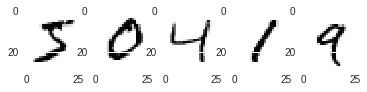

In [13]:
f, ax = plt.subplots(1,5)
# f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(x_train[i].reshape(28, 28))
plt.show()

##### CIFAR10

In [0]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

##### imdb dataset for movie rating and sentiment

In [0]:
from keras.datasets import imdb

(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

##### Fashion mnist has data arround picturs on cloths

In [0]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

##### Boston housing data for supervised learning to predict price

In [0]:
from keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

### We are using mnist data for handwritten digit recognition.

#### for RGB any image the intensity is defined by 0 to 255 . Hence deviding by 255 will range the new value 
#### from 0 - 1. This is kind of normalization of imgae spreadsheet.

In [0]:
## normalize and reshape
train_x = x_train/255.
val_x = x_test/255.

#### In our autoencoder network, we will add convolutional layers because convolutional networks works really well with the image inputs. To apply convolutions on image data, we will reshape our inputs in the form of 28 * 28 matrix

In [8]:
train_x.shape

(60000, 28, 28)

Let's observe some images

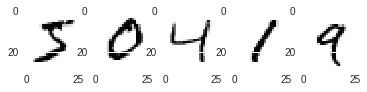

In [12]:
f, ax = plt.subplots(1,5)
# f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(train_x[i].reshape(28, 28))
plt.show()

### Reshaping the data to fit the model 
*  -1 represents : to keep the number of images consistant but add an image to it
* 28 , 28 ,1 represents (hight , width, channel)

In [0]:
train_x1 = train_x.reshape(-1, 28, 28, 1)
val_x1 = val_x.reshape(-1, 28, 28, 1)

In [10]:
train_x1.shape

(60000, 28, 28, 1)

**Noisy Images**

We can intentionally introduce the noise in an image. I am using imaug package which can be used to augment the images with different variations. One such variation can be introduction of noise. Different types of noises can be added to the images. For example:

*  Salt and Pepper Noise
*  Gaussian Noise
*  Periodic Noise
*  Speckle Noise

[https://imgaug.readthedocs.io/en/latest/]

In [0]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255

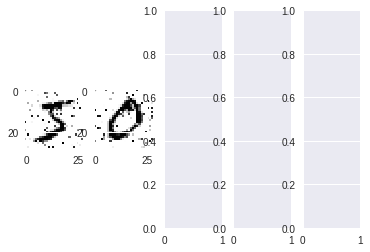

In [15]:
f, ax = plt.subplots(1,5)
# f.set_size_inches(80, 40)
for i in range(2):
    ax[i].imshow(train_x_n[i].reshape(28, 28))
plt.show()

### Check below for diferent augmentation on images 

[https://imgaug.readthedocs.io/en/latest/source/augmenters.html]

In [0]:
?augmenters.CoarseSaltAndPepper

In [0]:
# Lets add sample gaussianBlur
noise = augmenters.GaussianBlur(sigma=(0.0, 3.0))
seq_object = augmenters.Sequential([noise])


In [0]:
train_x_n = seq_object.augment_images(train_x[0:4] * 255) / 255


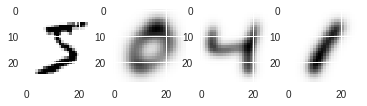

In [23]:
f, ax = plt.subplots(1,4)
# f.set_size_inches(80, 40)
for i in range(4):
    ax[i].imshow(train_x_n[i].reshape(28, 28))
plt.show()



In [0]:
matrix = np.array([[0, -1, 0],
                   [-1, 4, -1],
                   [0, -1, 0]])


# Lets add convolve
noise = augmenters.Convolve(matrix=matrix)
seq_object = augmenters.Sequential([noise])


In [0]:
train_x_n = seq_object.augment_images(train_x[0:4] * 255) / 255

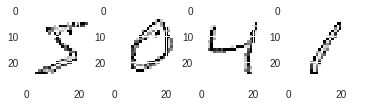

In [26]:
f, ax = plt.subplots(1,4)
# f.set_size_inches(80, 40)
for i in range(4):
    ax[i].imshow(train_x_n[i].reshape(28, 28))
plt.show()

In [0]:
# Lets add Sharpen
noise = augmenters.Sharpen(alpha=(0.0, 1.0), lightness=(0.75, 2.0))
seq_object = augmenters.Sequential([noise])

In [0]:
train_x_n = seq_object.augment_images(train_x[0:4] * 255) / 255

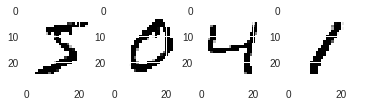

In [29]:
f, ax = plt.subplots(1,4)
# f.set_size_inches(80, 40)
for i in range(4):
    ax[i].imshow(train_x_n[i].reshape(28, 28))
plt.show()

In [0]:

# Lets Add values to the pixels of images with possibly different values for neighbouring pixels.
noise = augmenters.AddElementwise((-40, 40))
seq_object = augmenters.Sequential([noise])

In [0]:
train_x_n = seq_object.augment_images(train_x[0:4] * 255) / 255

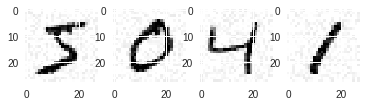

In [32]:
f, ax = plt.subplots(1,4)
# f.set_size_inches(80, 40)
for i in range(4):
    ax[i].imshow(train_x_n[i].reshape(28, 28))
plt.show()

In [0]:

# Lets Add addetive gaussan noise
noise = augmenters.AdditiveGaussianNoise(scale=(0, 0.05*255))
seq_object = augmenters.Sequential([noise])

In [0]:
train_x_n = seq_object.augment_images(train_x[0:4] * 255) / 255

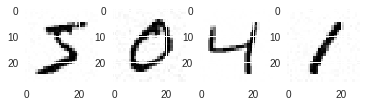

In [35]:
f, ax = plt.subplots(1,4)
# f.set_size_inches(80, 40)
for i in range(4):
    ax[i].imshow(train_x_n[i].reshape(28, 28))
plt.show()

In [0]:
#Augmenter that inverts all values in images, i.e. sets a pixel from value v to 255-v
noise = augmenters.Invert(0.5)
seq_object = augmenters.Sequential([noise])

In [0]:
train_x_n = seq_object.augment_images(train_x[0:4] * 255) / 255

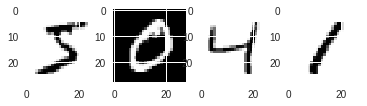

In [38]:
f, ax = plt.subplots(1,4)
# f.set_size_inches(80, 40)
for i in range(4):
    ax[i].imshow(train_x_n[i].reshape(28, 28))
plt.show()

In [0]:
#Augmenter to transform images by moving pixels locally around using displacement fields

noise = augmenters.ElasticTransformation(alpha=(0, 4.0), sigma=0.15)
seq_object = augmenters.Sequential([noise])

In [0]:
train_x_n = seq_object.augment_images(train_x[0:4] * 255) / 255

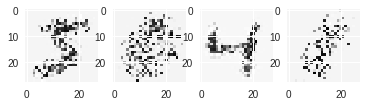

In [41]:
f, ax = plt.subplots(1,4)
# f.set_size_inches(80, 40)
for i in range(4):
    ax[i].imshow(train_x_n[i].reshape(28, 28))
plt.show()

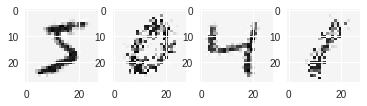

In [44]:
f, ax = plt.subplots(1,4)
# f.set_size_inches(80, 40)
for i in range(4):
    ax[i].imshow(train_x_n[i].reshape(28, 28))
plt.show()

### There are more kind of augmentors we can check from the link . We shall try some augmentation from keras data-gen as well:

#### We have used data gen and image augmentation combo for our training. Go below and find the fucton for more clarity

In [0]:
#keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)

*   featurewise_center: Boolean. Set input mean to 0 over the dataset, feature-wise.
*   samplewise_center: Boolean. Set each sample mean to 0.
*   featurewise_std_normalization: Boolean. Divide inputs by std of the dataset, feature-wise.
*   samplewise_std_normalization: Boolean. Divide each input by its std.
*   zca_epsilon: epsilon for ZCA whitening. Default is 1e-6.
*   zca_whitening: Boolean. Apply ZCA whitening.
*   rotation_range: Int. Degree range for random rotations.
*   width_shift_range: Float, 1-D array-like or int
*   float: fraction of total width, if < 1, or pixels if >= 1.
*   1-D array-like: random elements from the array.
*   int: integer number of pixels from interval  (-width_shift_range, +width_shift_range)
*   With width_shift_range=2 possible values are integers [-1, 0, +1], same as with  width_shift_range=[-1, 0, +1], while with width_shift_range=1.0 possible values are floats in the interval [-1.0, +1.0).
  *   height_shift_range: Float, 1-D array-like or int
  *   float: fraction of total height, if < 1, or pixels if >= 1.
  *   1-D array-like: random elements from the array.
  *   int: integer number of pixels from interval  (-height_shift_range, +height_shift_range)
*   With height_shift_range=2 possible values are integers [-1, 0, +1], same as with  height_shift_range=[-1, 0, +1], while with height_shift_range=1.0 possible values are floats in the interval [-1.0, +1.0).
*   brightness_range: Tuple or list of two floats. Range for picking a brightness shift value from.
*   shear_range: Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
*   zoom_range: Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
*   channel_shift_range: Float. Range for random channel shifts.
*   fill_mode: One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'. Points outside the boundaries of the input are filled according to the given mode:
  *   'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
  *   'nearest': aaaaaaaa|abcd|dddddddd
  *   'reflect': abcddcba|abcd|dcbaabcd
  *   'wrap': abcdabcd|abcd|abcdabcd
*   cval: Float or Int. Value used for points outside the boundaries when fill_mode = "constant".
*   horizontal_flip: Boolean. Randomly flip inputs horizontally.
*   vertical_flip: Boolean. Randomly flip inputs vertically.
*   rescale: rescaling factor. Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).
*   preprocessing_function: function that will be implied on each input. The function will run after the image is resized and augmented. The function should take one argument: one image (Numpy tensor with rank 3), and should output a Numpy tensor with the same shape.
*   data_format: Image data format, either "channels_first" or "channels_last". "channels_last" mode means that the images should have shape  (samples, height, width, channels), "channels_first" mode means that the images should have shape (samples, channels, height, width). It defaults to the image_data_format value found in your Keras config file at  ~/.keras/keras.json. If you never set it, then it will be "channels_last".
*   validation_split: Float. Fraction of images reserved for validation (strictly between 0 and 1).
*   dtype: Dtype to use for the generated arrays.


### Basic - Autoencoder network structure

#### When you define model "model_2 = Model(input_layer, output_layer)" you can actually take any of the layer as an output out of your defined network structure. 

#### Compile is a must step for each model to help the object to indicate from what layer to what layer the model should consider and what loss to be considered.


In [0]:
# input layer
input_layer = Input(shape=(28, 28, 1)) # shape(hight, width , channel)

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

In [12]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0         
__________

### Checking present working directory

In [51]:
!pwd

/content


### Defining different controls during learning 

*  **monitor:** quantity to be monitored. 
*  ** min_delta:**  minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement. 
*  ** patience:**  number of epochs with no improvement after which training will be stopped. 
*  ** verbose:**  verbosity mode. 
*  ** mode:**  one of {auto, min, max}. In min mode, training will stop when the quantity monitored has stopped decreasing; in max mode it will stop when the quantity monitored has stopped increasing; in auto mode, the direction is automatically inferred from the name of the monitored quantity. 
*  ** baseline:**  Baseline value for the monitored quantity to reach. Training will stop if the model doesn't show improvement over the baseline. 
*  ** restore_best_weights:**  whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used

In [0]:

model_checkpoint = ModelCheckpoint(filepath='gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
#tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=256, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
LR_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


### To check any class functions which is not documented on the internet

*  train_datagen. + TAB will give all available options.. then select any fuctions then pyt () ... go inside bracket and press TAB to see the dicumentations this is for COLAB...

* Normal jupyter press shift+TAB inside bracket

#### generating data from a loaded file: there are option on Keras datagen to either load from folder as well as load from data-frame

### Special note: we are adding the image augmentation as experimented before as part of DATAGEN

#### Writting a function to randomely select an augmentor and apply for the batch. Post which the data gen is also doing flips , rotation etc as additional step

In [59]:
np.random.randint(1,5)

1

#### Please note and check the VVI marked line of the code. we faced a problem that augmenter was not designed for (-1,28,28,1) kind of shape rather it consumes (-1,28,28) shape . 
##### However our network model consumes (-1,28,28,1)... 

Hence we converted the image two times in this function to suit the requirment . 

In [0]:
def random_image_augumenter(image_batch):
  
  image_batch = image_batch.reshape(-1,28,28)
  
  rnd = np.random.randint(1,7)
  if rnd == 1:
    noise = augmenters.GaussianBlur(sigma=(0.0, 3.0))
    seq_object = augmenters.Sequential([noise])
    X = seq_object.augment_images(image_batch)
  elif rnd == 2:
    noise = augmenters.ElasticTransformation(alpha=(0, 4.0), sigma=0.15)
    seq_object = augmenters.Sequential([noise])
    X = seq_object.augment_images(image_batch)
  elif rnd == 3:
    noise = augmenters.Invert(0.5)
    seq_object = augmenters.Sequential([noise])
    X = seq_object.augment_images(image_batch)
  elif rnd == 4:
    noise = augmenters.AdditiveGaussianNoise(scale=(0, 0.05*255))
    seq_object = augmenters.Sequential([noise])
    X = seq_object.augment_images(image_batch)
  elif rnd == 5:
    noise = augmenters.AddElementwise((-40, 40))
    seq_object = augmenters.Sequential([noise])
    X = seq_object.augment_images(image_batch)
  elif rnd == 6:
    matrix = np.array([[0, -1, 0],
                   [-1, 4, -1],
                   [0, -1, 0]])
    # Lets add convolve
    noise = augmenters.Convolve(matrix=matrix)
    seq_object = augmenters.Sequential([noise])
    X = seq_object.augment_images(image_batch)
  elif rnd == 7:
    noise = augmenters.SaltAndPepper(0.1)
    seq_object = augmenters.Sequential([noise])
    X = seq_object.augment_images(image_batch)
  else:
    noise = augmenters.GaussianBlur(sigma=(0.0, 3.0))
    seq_object = augmenters.Sequential([noise])
    X = seq_object.augment_images(image_batch)
  
  
  X = X.reshape(-1,28,28,1) # VVI 
  #print(X.shape)
  return X
  

#### Defining data generator with preprocessing as random_image_augmenter

In [0]:
train_datagen = ImageDataGenerator(
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True
        ,preprocessing_function = random_image_augumenter
)

#### For validation we are not using any augmentation . just batch by batch processing

In [0]:
val_datagen = ImageDataGenerator()


In [0]:
# train_datagen = ImageDataGenerator(
#         rotation_range = 40,
#         width_shift_range = 0.2,
#         height_shift_range = 0.2,
#         shear_range = 0.2,
#         zoom_range = 0.2,
#         horizontal_flip = True
#         ,preprocessing_function = seq_object.augment_images
# )



#### Generating data from preloaded file:

Use ImageDataGenerator.flow

##### Note: datagen apply the tricks only on  training set not on validation set. Now we have noisy and augmented images on training side. But clean image on the testing side........ FUN right? 

In [0]:
#as we are using pre loaded data we shall use Flow function on ImageDataGenerator


train_generator = train_datagen.flow(train_x1, y= train_x1, batch_size=256, shuffle=True, seed=9 )

In [0]:
valid_generator = val_datagen.flow(val_x1,y= val_x1, batch_size=256, shuffle=True, seed=9)

##### Testing whether augmented input-X and testing input-X is same or not

In [0]:
#gen = train_generator.next()

Returns
    An `Iterator` yielding tuples of `(x, y)`
        where `x` is a numpy array of image data
        (in the case of a single image input) or a list
        of numpy arrays (in the case with
        additional inputs) and `y` is a numpy array
        of corresponding labels. If 'sample_weight' is not None,
        the yielded tuples are of the form `(x, y, sample_weight)`.
        If `y` is None, only the numpy array `x` is returned.

In [49]:
#gen[0].shape

(256, 28, 28, 1)

In [50]:
#np.allclose(gen[0],gen[1])

False

In [45]:
#np.allclose(train_generator.x, train_x1)

True

### Generating data from DATAFRAME

##### ImageDataGenerator.flow from dataframe

In [0]:
# train_generator = train_datagen.flow_from_directory(
#         "dataset//train",
#         target_size = TARGET_SIZE, 
#         batch_size = BATCH_SIZE, 
#         class_mode = "categorical")


In [0]:
# validation_generator = train_datagen.flow_from_directory(
#         "dataset//valid", 
#         target_size = TARGET_SIZE, 
#         batch_size = BATCH_SIZE, 
#         class_mode = "categorical")

In [0]:
# !ls dataset//test|head

In [0]:
# model.fit_generator(
#         generator = train_generator,
#         epochs = 50,
#         callbacks = [checkpoint, earlystop, reducelr,tbCallBack],
#         validation_data = validation_generator,
#         verbose = 1)

In [0]:
# predictions = model.predict_generator(
#         test_generator,
#         verbose = 1)

In [0]:
# history = model_2.fit(train_x_n, train_x, epochs=10, batch_size=256, validation_data=(val_x_n, val_x), callbacks=[early_stopping,model_checkpoint,LR_reducer])

### We are now ready to start the training

In [69]:
history = model_2.fit_generator(
    generator = train_generator,
    epochs = 10,
    steps_per_epoch= 235,
    validation_steps= 40,
    callbacks = [early_stopping,model_checkpoint,LR_reducer],
    validation_data = valid_generator,
    verbose = 1,use_multiprocessing=True).history
              

Epoch 1/10
235/235 [==============================] - 52s 221ms/step - loss: 0.0679 - val_loss: 0.0662

Epoch 00001: saving model to gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5
Epoch 2/10
235/235 [==============================] - 51s 218ms/step - loss: 0.0674 - val_loss: 0.0653

Epoch 00002: saving model to gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5
Epoch 3/10
235/235 [==============================] - 52s 222ms/step - loss: 0.0670 - val_loss: 0.0647

Epoch 00003: saving model to gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5
Epoch 4/10
235/235 [==============================] - 52s 221ms/step - loss: 0.0667 - val_loss: 0.0638

Epoch 00004: saving model to gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5
Epoch 5/10
235/235 [==============================] - 52s 221ms/step - loss: 0.0665 - val_loss: 0.0632

Epoc

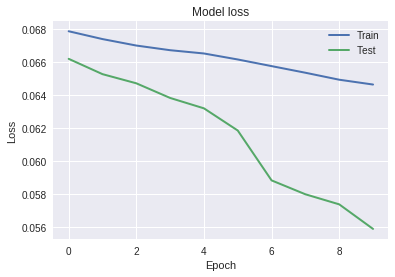

In [70]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [22]:
val_x1.shape

(10000, 28, 28, 1)

#### We are keeping the checkpint dsaved in the drive and hence we can do incremental learning by simply loading the model and start the training again.

In [75]:
from keras.models import load_model

# returns a compiled model,identical to the previous run
model_3 = load_model('gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5')
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0         
__________

### Another run

In [76]:
history2 = model_3.fit_generator(
    generator = train_generator,
    epochs = 20,
    steps_per_epoch= 235,
    validation_steps= 40,
    callbacks = [early_stopping,model_checkpoint,LR_reducer],
    validation_data = valid_generator,
    verbose = 1,use_multiprocessing=True).history
              

Epoch 1/20
235/235 [==============================] - 52s 221ms/step - loss: 0.0645 - val_loss: 0.0569

Epoch 00001: saving model to gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5
Epoch 2/20
235/235 [==============================] - 52s 222ms/step - loss: 0.0642 - val_loss: 0.0549

Epoch 00002: saving model to gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5
Epoch 3/20
235/235 [==============================] - 52s 223ms/step - loss: 0.0640 - val_loss: 0.0560

Epoch 00003: saving model to gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5
Epoch 4/20
235/235 [==============================] - 52s 221ms/step - loss: 0.0639 - val_loss: 0.0542

Epoch 00004: saving model to gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5
Epoch 5/20
235/235 [==============================] - 52s 223ms/step - loss: 0.0636 - val_loss: 0.0547

Epoc

In [79]:
history.keys()

dict_keys(['val_loss', 'loss', 'lr'])

In [80]:
history['loss']

[0.06788589401245117,
 0.06741116189559301,
 0.06701922213236491,
 0.06673663191397985,
 0.06653810713688532,
 0.06617485634088516,
 0.06577280365427335,
 0.06537100202639898,
 0.06494814011653265,
 0.06465571308135987]

#### Adding both the run loss values to see overall graph

In [0]:
history_cum = history
history_cum['loss'].extend(history2['loss'])
history_cum['val_loss'].extend(history2['val_loss'])

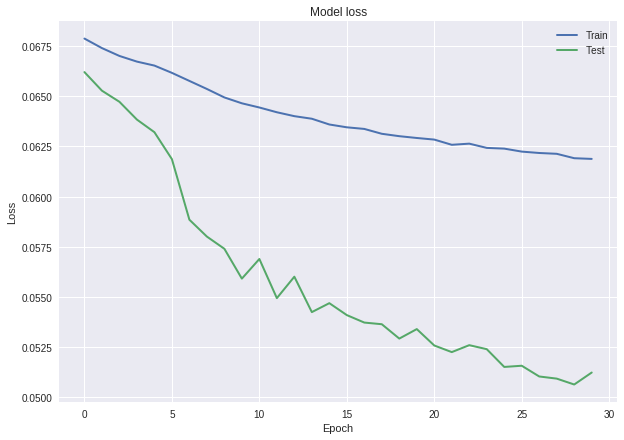

In [86]:
plt.figure(figsize=(10,7))
plt.plot(history_cum['loss'], linewidth=2, label='Train')
plt.plot(history_cum['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

#### Below is the way to completely change the data or augment the data and then use it normally batch by batch..... Personally neither me nor Jitin liked this idea... we want evrything on go.

In [0]:
#train_x_augmented = train_datagen.fit(train_x1,augment=True)

In [0]:
#history = model_4.fit(train_x_augmented, train_x1, epochs=10, batch_size=256, validation_data=(val_x1, val_x1), callbacks=[early_stopping,model_checkpoint,LR_reducer])

# Variational de-noising auto encoder -KP-JK version

#### Sampling block

In [0]:
gaussian_spread_sigma = 1.0

# to generate sample at bottleneck
def sampling(args):
    bottleneck, bottleneck_log_var = args
    
    posterior_gaussian = K.random_normal(shape=(K.shape(bottleneck)[0], encoding_dim), mean=0.,
                              stddev=gaussian_spread_sigma)
    
    return bottleneck + K.exp(bottleneck_log_var / 2) * posterior_gaussian

     
  
    

#### Variational - Bays block

In [0]:
# defining variational loss for training
# vae_losses=[]
# reconstruction_loss=[]
# KL_divergance=[]
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(losses.mean_squared_error(y_pred, y_true))
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    # check for 0.5 multiplication
    kl = 0.5 * K.sum(K.exp(bottleneck_log_var) + K.square(bottleneck) - 1. - bottleneck_log_var, axis=1)

    return recon + kl

#### What is the arry size of latent representation you want?

In [0]:
encoding_dim = 36
# learning_rate = 1e-7
# input_dim = train_x.shape[1]


#### Lambda function to help apply the sampling and variational bays blok on the run--- during training time
##### the fun part is the reshape. this has really disturbed us for a while..... Actually there is a tensor size mismatch 

In [0]:
from keras.layers import Flatten,Lambda,Reshape
from keras import backend as K
from keras import losses

####  Better the check the structure of the flatten layer before building dense leyers after this...


#### Also check how can you convert back this flatten or dense (on the decoder layer ) into (z,[x,y]) format.. so that "X,Y, Z multiplication should be equal to the previous dence layer and represents a larger frame compared to the next layer

In [98]:
# input layer
input_layer = Input(shape=(28, 28, 1)) # shape(hight, width , channel)

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)
# layer 3 = total size = 16*3*3 = 144 this diveded by [2,2 max pull = 144/4= 36]
flatten_view  = Flatten()(latent_view)


encoded3 = Dense(36, activation = 'relu')(flatten_view)
bottleneck = Dense(encoding_dim, activation = 'relu')(encoded3)
bottleneck_log_var= Dense(encoding_dim, activation = 'relu')(encoded3)

# note that "output_shape" isn't necessary with the TensorFlow backend
bottleneck_sample = Lambda(sampling, output_shape=(encoding_dim,))([bottleneck, bottleneck_log_var])
# Decoder Layers
decoded1 = Dense(36, activation = 'relu')(bottleneck_sample)





# # decoding architecture
# decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
# decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
# decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
# decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
# decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
# decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
# output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
model_5 = Model(input_layer, decoded1)
# model_2.compile(optimizer='adam', loss='mse')
model_5.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 28, 28, 64)   640         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_19 (MaxPooling2D) (None, 14, 14, 64)   0           conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 14, 14, 32)   18464       max_pooling2d_19[0][0]           
__________________________________________________________________________________________________
max_poolin

### Our variational denoising autoencoder structure 

In [110]:
# input layer
input_layer = Input(shape=(28, 28, 1)) # shape(hight, width , channel)

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)
# Best practice print and check .. flatten has how many points
flatten_view  = Flatten()(latent_view)


encoded3 = Dense(128, activation = 'relu')(flatten_view)
bottleneck = Dense(encoding_dim, activation = 'relu')(encoded3)
bottleneck_log_var= Dense(encoding_dim, activation = 'relu')(encoded3)

# note that "output_shape" isn't necessary with the TensorFlow backend
bottleneck_sample = Lambda(sampling, output_shape=(encoding_dim,))([bottleneck, bottleneck_log_var])
# Decoder Layers
decoded1 = Dense(128, activation = 'relu')(bottleneck_sample)

decoded2 = Dense(256, activation = 'relu')(bottleneck_sample)

decoded_layer0 = Reshape((4, 4, 16))(decoded2)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(decoded_layer0)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
model_6 = Model(input_layer, output_layer)
model_6.compile(optimizer='adam', loss = vae_loss)
model_6.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 28, 28, 64)   640         input_11[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_31 (MaxPooling2D) (None, 14, 14, 64)   0           conv2d_43[0][0]                  
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 14, 14, 32)   18464       max_pooling2d_31[0][0]           
__________________________________________________________________________________________________
max_poolin

#### Training the network..... 

In [111]:
history_vae = model_6.fit_generator(
    generator = train_generator,
    epochs = 5,
    steps_per_epoch= 235,
    validation_steps= 40,
    callbacks = [early_stopping,model_checkpoint,LR_reducer],
    validation_data = valid_generator,
    verbose = 1,use_multiprocessing=True).history

Epoch 1/5
235/235 [==============================] - 54s 230ms/step - loss: 24417551470866160.0000 - val_loss: 122320.0441

Epoch 00001: saving model to gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5
Epoch 2/5
235/235 [==============================] - 52s 221ms/step - loss: 123368.2851 - val_loss: 121953.9104

Epoch 00002: saving model to gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5
Epoch 3/5
235/235 [==============================] - 53s 226ms/step - loss: 122711.9639 - val_loss: 119985.4896

Epoch 00003: saving model to gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5
Epoch 4/5
235/235 [==============================] - 52s 223ms/step - loss: 121887.6108 - val_loss: 120014.6905

Epoch 00004: saving model to gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5
Epoch 5/5
235/235 [==============================] - 52s 223m

## Adding all inteanal losses

#### We aim to understand different papameters during the model train to get a better picture of the learning. Overall VAE loss is not enough. We designed a fuction to store all the interal losses and plot them to get the idea of training.

In [0]:
#sklearn's imports
from sklearn.metrics import mean_squared_error, mean_absolute_error

import keras

In [0]:
# defining callback history

class Histories(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.mse = []
        self.mae = []
        self.mape= []
        self.losses = []
 
    def on_train_end(self, logs={}):
        return
 
    def on_epoch_begin(self, epoch, logs={}):
        return
 
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        y_pred = self.model.predict(self.model.validation_data[0])
        self.mse.append(mean_squared_error(self.model.validation_data[1], y_pred))
        self.mae.append(mean_absolute_error(self.model.validation_data[1], y_pred))
        self.mape.append(mean_absolute_percentage_error(self.model.validation_data[1], y_pred))
        return
 
    def on_batch_begin(self, batch, logs={}):
        return
 
    def on_batch_end(self, batch, logs={}):
        return

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure(figsize=(15,15))
        
        self.logs = []
        self.mse = []
        self.mae = []
        self.mape= []
        self.val_mse = []
        self.val_mae = []
        self.val_mape= []


    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.mse.append(logs.get('mean_squared_error'))
        self.mae.append(logs.get('mean_absolute_error'))
        self.mape.append(logs.get('mean_absolute_percentage_error'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_mse.append(logs.get('val_mean_squared_error'))
        self.val_mae.append(logs.get('val_mean_absolute_error'))
        self.val_mape.append(logs.get('val_mean_absolute_percentage_error'))
        self.i += 1
        
        # uncomment this if we want to see the plot changeing at every epoch
#         clear_output(wait=True)
#         plt.subplot(2,2,1)
#         plt.plot(self.x, self.losses, label="loss")
#         plt.plot(self.x, self.val_losses, label="val_loss")
#         plt.title('Loss Metrics')
#         plt.legend()
        
#         plt.subplot(2,2,2)
#         plt.plot(self.x, self.mape, label="mape")
#         plt.plot(self.x, self.val_mape, label="val_mape")
#         plt.title('MAPE Metric')
#         plt.legend()

#         plt.subplot(2,2,3)
#         plt.plot(self.x, self.mse, label="mse")
#         plt.plot(self.x, self.val_mse, label="val_mse")
#         plt.title('MSE Metric')
#         plt.legend()
        
#         plt.subplot(2,2,4)
#         plt.plot(self.x, self.mae, label="mae")
#         plt.plot(self.x, self.val_mae, label="val_mae")
#         plt.title('MAE Metric')
#         plt.legend()
#         plt.show();
    
    def on_train_end(self, logs={}):
        plt.subplot(2,2,1)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.title('Loss Metrics')
        plt.legend()
        
        plt.subplot(2,2,2)
        plt.plot(self.x, self.mape, label="mape")
        plt.plot(self.x, self.val_mape, label="val_mape")
        plt.title('MAPE Metric')
        plt.legend()

        plt.subplot(2,2,3)
        plt.plot(self.x, self.mse, label="mse")
        plt.plot(self.x, self.val_mse, label="val_mse")
        plt.title('MSE Metric')
        plt.legend()
        
        plt.subplot(2,2,4)
        plt.plot(self.x, self.mae, label="mae")
        plt.plot(self.x, self.val_mae, label="val_mae")
        plt.title('MAE Metric')
        plt.legend()
        plt.show();

histories = Histories()        
plot_losses = PlotLosses()

### Again defining the network structure. Please check VVI marked code... wil give idea how to use these metrics

In [114]:
# input layer
input_layer = Input(shape=(28, 28, 1)) # shape(hight, width , channel)

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)
# Best practice print and check .. flatten has how many points
flatten_view  = Flatten()(latent_view)


encoded3 = Dense(128, activation = 'relu')(flatten_view)
bottleneck = Dense(encoding_dim, activation = 'relu')(encoded3)
bottleneck_log_var= Dense(encoding_dim, activation = 'relu')(encoded3)

# note that "output_shape" isn't necessary with the TensorFlow backend
bottleneck_sample = Lambda(sampling, output_shape=(encoding_dim,))([bottleneck, bottleneck_log_var])
# Decoder Layers
decoded1 = Dense(128, activation = 'relu')(bottleneck_sample)

decoded2 = Dense(256, activation = 'relu')(bottleneck_sample)

decoded_layer0 = Reshape((4, 4, 16))(decoded2)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(decoded_layer0)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
model_7 = Model(input_layer, output_layer)
model_7.compile(optimizer='adam', loss = vae_loss,metrics=['mse','mape','mae']) # VVI
model_7.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 28, 28, 64)   640         input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_34 (MaxPooling2D) (None, 14, 14, 64)   0           conv2d_50[0][0]                  
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 14, 14, 32)   18464       max_pooling2d_34[0][0]           
__________________________________________________________________________________________________
max_poolin

# Now relax, take a cup of coffee and enjoy the show......... before running tell your computer .. ALLL THE BEST BUDDY...... 

## Don't forget------ Kumarjit & Jitin

Epoch 1/5
235/235 [==============================] - 56s 236ms/step - loss: 6463965031.0597 - mean_squared_error: 31185.8154 - mean_absolute_percentage_error: 2777988472.2993 - mean_absolute_error: 3.4624 - val_loss: 15378.2659 - val_mean_squared_error: 0.0759 - val_mean_absolute_percentage_error: 88135793.3184 - val_mean_absolute_error: 0.1777

Epoch 00001: saving model to gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5
Epoch 2/5
235/235 [==============================] - 52s 220ms/step - loss: 15124.2743 - mean_squared_error: 0.0748 - mean_absolute_percentage_error: 87870349.4265 - mean_absolute_error: 0.1758 - val_loss: 15001.4568 - val_mean_squared_error: 0.0741 - val_mean_absolute_percentage_error: 91513509.7472 - val_mean_absolute_error: 0.1773

Epoch 00002: saving model to gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5
Epoch 3/5
235/235 [==============================] - 54s 228ms/step - loss: 1

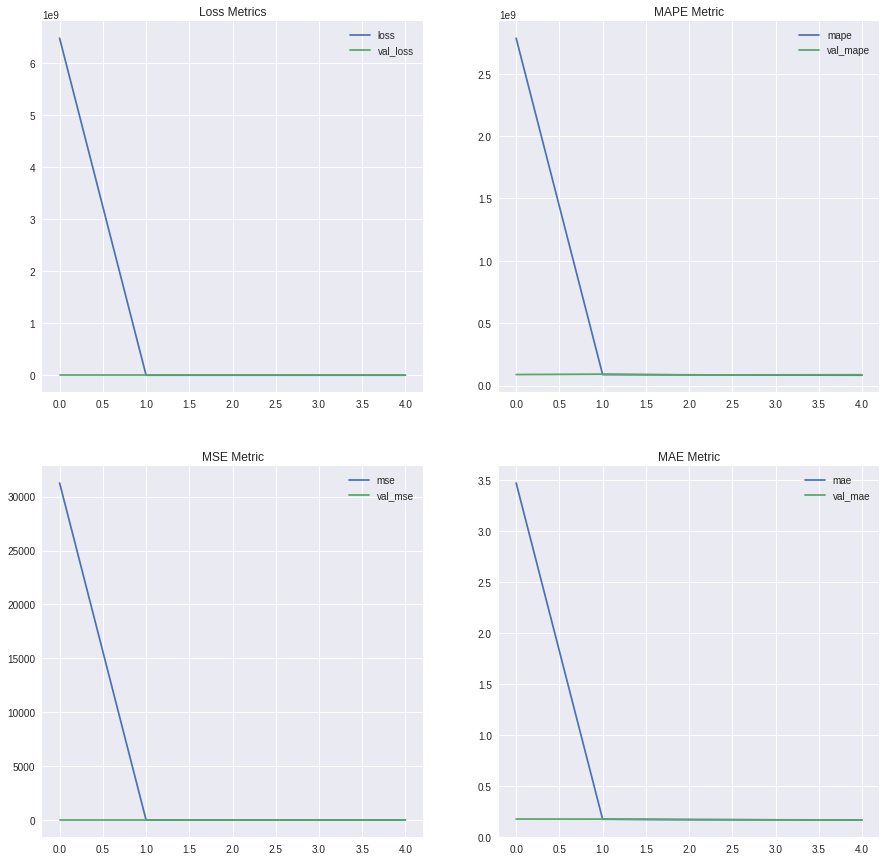

In [115]:
history_vae1 = model_7.fit_generator(
    generator = train_generator,
    epochs = 5,
    steps_per_epoch= 235,
    validation_steps= 40,
    callbacks = [early_stopping,model_checkpoint,LR_reducer,plot_losses],
    validation_data = valid_generator,
    verbose = 1,use_multiprocessing=True).history

Epoch 1/15
235/235 [==============================] - 54s 231ms/step - loss: 14331.0982 - mean_squared_error: 0.0710 - mean_absolute_percentage_error: 82928076.0611 - mean_absolute_error: 0.1683 - val_loss: 13946.4478 - val_mean_squared_error: 0.0689 - val_mean_absolute_percentage_error: 88285268.2624 - val_mean_absolute_error: 0.1692

Epoch 00001: saving model to gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5
Epoch 2/15
235/235 [==============================] - 54s 230ms/step - loss: 14270.1091 - mean_squared_error: 0.0707 - mean_absolute_percentage_error: 82562304.1217 - mean_absolute_error: 0.1678 - val_loss: 13934.9961 - val_mean_squared_error: 0.0689 - val_mean_absolute_percentage_error: 87249781.8624 - val_mean_absolute_error: 0.1686

Epoch 00002: saving model to gdrive/My Drive/Data Science Experiment/Autoencoder Experiment/Image/autoencoder_image.h5
Epoch 3/15
235/235 [==============================] - 54s 231ms/step - loss: 14227.918

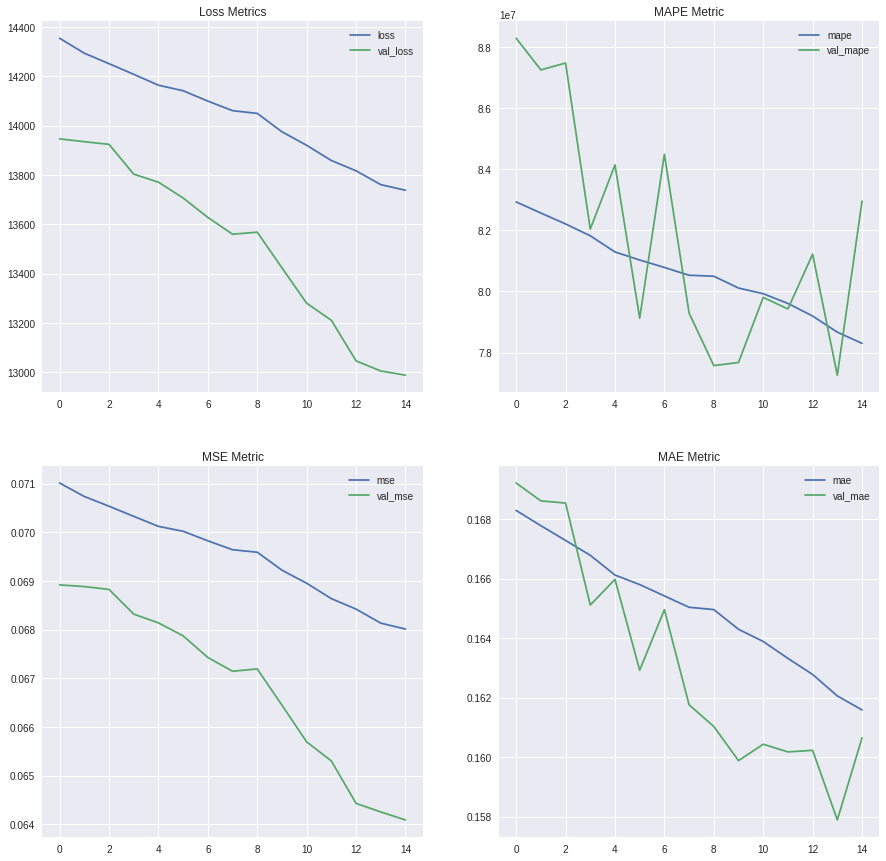

In [116]:
history_vae2 = model_7.fit_generator(
    generator = train_generator,
    epochs = 15,
    steps_per_epoch= 235,
    validation_steps= 40,
    callbacks = [early_stopping,model_checkpoint,LR_reducer,plot_losses],
    validation_data = valid_generator,
    verbose = 1,use_multiprocessing=True).history

# Big THANK YOU ... HOPE YOU enjoyed the TRAILER